# Entity Resolution
## Data Loading and Cleanup

In [1]:
import json
import pandas as pd
import math
import numpy as np
import streetaddress as sa
from difflib import SequenceMatcher

PATH = "Prakhar/er-assignment/fs/Instabase%20Drive/files/datasets/"
FILES = {
    "foursquare_test": "foursquare_test_hard.json",
    "locu_test": "locu_test_hard.json",
    "matches": "matches_train_hard.csv",
    "foursquare_train": "foursquare_train_hard.json",
    "locu_train": "locu_train_hard.json"
}

In [2]:
# Normalizes street addresses using the streetaddress library. All normalized fields are added as columns
def addr_parse(address):
    if address is not None: 
        addr_parser = sa.StreetAddressParser()
        addr = addr_parser.parse(address)
        format = {'house': [addr['house']],
                  'street_name': [addr['street_name']],
                  'street_type': [addr['street_type']],
                  'suite_num': [addr['suite_num']],
                  'suite_type': [addr['suite_type']] }   
    else: 
        format = {'house': [None],
                  'street_name': [None],
                  'street_type': [None],
                  'suite_num': [None],
                  'suite_type': [None] }
    rv = pd.DataFrame(data = format)
    return rv

# fs_train = pd.read_json(ib.open(PATH + FILES["foursquare_train"]))
# fs_test = pd.read_json(ib.open(PATH + FILES["foursquare_test"]))
# lc_train = pd.read_json(ib.open(PATH + FILES["locu_train"]))
# lc_test = pd.read_json(ib.open(PATH + FILES["locu_test"]))
# matches = pd.read_csv(ib.open(PATH + FILES["matches"]))
fs_train = pd.read_json('data/foursquare_train_hard.json')
fs_test = pd.read_json('data/foursquare_test_hard.json')
lc_train = pd.read_json('data/locu_train_hard.json')
lc_test = pd.read_json('data/locu_test_hard.json')
matches = pd.read_csv('data/matches_train_hard.csv')

data_list = [fs_train, fs_test, lc_train, lc_test]

for df in data_list:
    df.drop(['country', 'region', 'locality'], inplace=True, axis=1)
    
    df.replace([''], [None], inplace=True)
    
    df['id'] = df['id'].astype('str')
    df['latitude'] = pd.to_numeric(df['latitude'])
    df['longitude'] = pd.to_numeric(df['longitude'])
#     df['locality'] = df['locality'].astype('str')
    
    # Unicode chars to replace
    df['name'].replace([u"\xe9"], ['e'], regex=True, inplace=True)
    df['name'].replace([u"\xed"], ['i'], regex=True, inplace=True)
    df['name'].replace([u'\u2019'], [''], regex=True, inplace=True)
    df['name'].replace([u'\xc7'], ['c'], regex=True, inplace=True)
    df['name'].replace([u'\u2013'], ['-'], regex=True, inplace=True)
    
    df['name'].replace([r':|\'|,|\.|-'], [''], regex=True, inplace=True)
    df['name'].replace(['&'], ['and'], regex=True, inplace=True)
    df['name'].replace(['\s+|\/'], [' '], regex=True, inplace=True)
    df['name'].replace(['\s'], [''], regex=True, inplace=True)

    df['name'] = df['name'].astype(str).str.lower()
    
    df['phone'].replace([r'\(|\)|\s|-'], [''], regex=True, inplace=True)
    
    df['street_address'].replace([r'<sup>|<\/sup>'], [''], regex=True, inplace=True)
    df['street_address'] = df['street_address'].astype(str)
    
    df['website'].replace([u"\u200e"], [''], regex=True, inplace=True)
    df['website'].replace([r'http(s)?://(www.)?|\\u200e'], [''], regex=True, inplace=True)
    df['website'].replace([r'\..*'], [''], regex=True, inplace=True)
    df['website'] = df['website'].astype(str).str.lower()
    df['website'].replace(['None'], [None], inplace=True)
    
    
c = fs_train['street_address'].apply(addr_parse)
cols = pd.concat([i for i in c]).reset_index(drop=True)
fs_train = pd.concat([fs_train,cols], axis = 1)

c = fs_test['street_address'].apply(addr_parse)
cols = pd.concat([i for i in c]).reset_index(drop=True)
fs_test = pd.concat([fs_test,cols], axis = 1)

c = lc_train['street_address'].apply(addr_parse)
cols = pd.concat([i for i in c]).reset_index(drop=True)
lc_train = pd.concat([lc_train,cols], axis = 1)

c = lc_test['street_address'].apply(addr_parse)
cols = pd.concat([i for i in c]).reset_index(drop=True)
lc_test = pd.concat([lc_test,cols], axis = 1)

Append a prefix to identify the columns when concatenated:

In [3]:
for df in [fs_train, fs_test]:
    df.columns = ['fs_' + str(i) for i in list(df.columns)]
for df in [lc_train, lc_test]:
    df.columns = ['lc_' + str(i) for i in list(df.columns)]

## Create Row Combinations
LC data is repeated row at a time, then FS data is repeated entirely at a time. The two are concatenated to create the combo data frame.

In [4]:
train_left =  lc_train.loc[np.repeat(lc_train.index.values, len(lc_train))].reset_index(drop=True)
train_right =  pd.concat([fs_train]*len(fs_train), ignore_index=True)
train = pd.concat([train_left, train_right], axis=1)

test_left =  lc_test.loc[np.repeat(lc_test.index.values, len(lc_test))].reset_index(drop=True)
test_right =  pd.concat([fs_test]*len(fs_test), ignore_index=True)
test = pd.concat([test_left, test_right], axis=1)

## Similarity Functions

In [5]:
def find_distance(pt1, pt2):
    return math.sqrt( (pt1[0] - pt2[0])**2 + (pt1[1] - pt2[1])**2 )
    
def string_similarity(str1, str2):
  return SequenceMatcher(None, str1, str2).ratio()

def lcs(s1, s2):
    m = [[0] * (1 + len(s2)) for i in xrange(1 + len(s1))]
    longest, x_longest = 0, 0
    for x in xrange(1, 1 + len(s1)):
        for y in xrange(1, 1 + len(s2)):
            if s1[x - 1] == s2[y - 1]:
                m[x][y] = m[x - 1][y - 1] + 1
                if m[x][y] > longest:
                    longest = m[x][y]
                    x_longest = x
            else:
                m[x][y] = 0
                
    return len(s1[x_longest - longest: x_longest])

## Computed Columns
### Match status

In [6]:
# Match dictionary
match_dict = {}
for i, row in matches.iterrows():
    match_dict[row['locu_id']] = row['foursquare_id']

In [7]:
match_column = []
for i, row in train.iterrows():
    lc_id = row['lc_id']
    fs_id = row['fs_id']
    if (lc_id in match_dict) and (match_dict[lc_id] == fs_id):
        match_column.append(1)
    else:
        match_column.append(0)
match_column = np.array(match_column)

### Various Distances

In [33]:
data_list = [train, test]

for d_i, df in enumerate(data_list):
    print("#####\nStarting iteration #{}".format(d_i))
    
    print('Processing distances...')
    distance = []
    for i, row in df.iterrows():
        lc_loc = (row['lc_latitude'], row['lc_longitude'])
        fs_loc = (row['fs_latitude'], row['fs_longitude'])
        distance.append(find_distance(lc_loc, fs_loc))

    print('Processing names...')
    name_dist = []
    for i, row in df.iterrows():
        lc_name = row['lc_name']
        fs_name = row['fs_name']
        name_dist.append(string_similarity(lc_name, fs_name))

    print('Processing ZIP codes...')
    zip_dist = []
    zip_missing = []
    for i, row in df.iterrows():
        lc_zip = row['lc_postal_code']
        fs_zip = row['fs_postal_code']
        if lc_zip and fs_zip:
            zip_dist.append(string_similarity(lc_zip, fs_zip))
#             zip_missing.append(0)
        else:
            zip_dist.append(np.nan)
#             zip_missing.append(1)

    print('Processing phone numbers...')
    phone_dist = []
    phone_missing = []
    for i, row in df.iterrows():
        lc_phone = row['lc_phone']
        fs_phone = row['fs_phone']
        if lc_phone and fs_phone:
            phone_dist.append(string_similarity(lc_phone, fs_phone))
#             phone_missing.append(0)
        else:
            phone_dist.append(np.nan)
#             phone_missing.append(1)

    print('Processing URLs...')
    url_dist = []
    url_missing = []
    for i, row in df.iterrows():
        lc_url = row['lc_website']
        fs_url = row['fs_website']
        if lc_url and fs_url:
            url_dist.append(string_similarity(lc_url, fs_url))
#             url_missing.append(0)
        else:
            url_dist.append(np.nan)
#             url_missing.append(1)
            
#     print('Processing street addresses...')
#     house_sim, house_missing = [], []
#     street_name_sim, street_name_missing = [], []
#     street_type_sim, street_type_missing = [], []
#     suite_num_sim, suite_num_missing = [], []
#     suite_type_sim, suite_type_missing = [], []
#     for i, row in df.iterrows():
#         lc_house = row['lc_house']
#         fs_house = row['fs_house']
        
#         lc_street_name = row['lc_street_name']
#         fs_street_name = row['fs_street_name']
        
#         lc_street_type = row['lc_street_type']
#         fs_street_type = row['fs_street_type']
        
#         lc_suite_num = row['lc_suite_num']
#         fs_suite_num = row['fs_suite_num']
        
#         lc_suite_type = row['lc_suite_type']
#         fs_suite_type = row['fs_suite_type']
        
#         if lc_house and fs_house:
#             house_sim.append(string_similarity(lc_house, fs_house))
#             house_missing.append(0)
#         else:
#             house_sim.append(np.nan)
#             house_missing.append(1)
        
#         if lc_street_name and fs_street_name:
#             street_name_sim.append(string_similarity(lc_street_name, fs_street_name))
#             street_name_missing.append(0)
#         else:
#             street_name_sim.append(np.nan)
#             street_name_missing.append(1)
            
#         if lc_street_type and fs_street_type:
#             street_type_sim.append(string_similarity(lc_street_type, fs_street_type))
#             street_type_missing.append(0)
#         else:
#             street_type_sim.append(np.nan)
#             street_type_missing.append(1)
        
#         if lc_suite_num and fs_suite_num:
#             suite_num_sim.append(string_similarity(lc_suite_num, fs_suite_num))
#             suite_num_missing.append(0)
#         else:
#             suite_num_sim.append(np.nan)
#             suite_num_missing.append(1)
        
#         if lc_suite_type and fs_suite_type:
#             suite_type_sim.append(string_similarity(lc_suite_type, fs_suite_type))
#             suite_type_missing.append(0)
#         else:
#             suite_type_sim.append(np.nan)
#             suite_type_missing.append(1)
            
#     print('Processing LCS...')
#     lcs = []
#     for i, row in df.iterrows():
#         lc_name = row['lc_name']
#         fs_name = row['fs_name']
#         lcs.append(lcs(lc_name, fs_name))
    
    d = {'distance': distance,
         'name_sim': name_dist,
         'zip_sim': zip_dist,  #'zip_missing': zip_missing,
         'phone_sim': phone_dist, #'phone_missing': phone_missing,
         'url_sim': url_dist}#, 'url_missing': url_missing }
#          'house_sim': house_sim, 'house_missing': house_missing,
#          'street_name_sim': street_name_sim, 'street_name_missing': street_name_missing,
#          'street_type_sim': street_type_sim, 'street_type_missing': street_type_missing,
#          'suite_num_sim': suite_num_sim, 'suite_num_missing': suite_num_missing,
#          'suite_type_sim': suite_type_sim, 'suite_type_missing': suite_type_missing,
#          'lcs': lcs }
    
    if d_i == 0:
        train_data = pd.DataFrame(d).fillna(0)
    else:
        test_data = pd.DataFrame(d).fillna(0)

print("#####\nProcessing Finished!")

#####
Starting iteration #0
Processing distances...
Processing names...
Processing ZIP codes...
Processing phone numbers...
Processing URLs...
#####
Starting iteration #1
Processing distances...
Processing names...
Processing ZIP codes...
Processing phone numbers...
Processing URLs...
#####
Processing Finished!


### Impute missing values

In [9]:
from sklearn.preprocessing import Imputer

ip = Imputer(missing_values = 'NaN')
ip.fit(pd.concat([train_data, test_data], axis=0))

train_data = pd.DataFrame(ip.fit_transform(train_data))
test_data = pd.DataFrame(ip.fit_transform(test_data))

## Model Training
* To-do: Output probabilities in order to break ties efficiently
* Hyperparameter Tuning

### Classifiers

In [10]:
from sklearn.cross_validation import StratifiedKFold
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

def cv_run_ada(train_data, train_labels, test_data, test_labels):
    model = AdaBoostClassifier(random_state=1).fit(train_data, train_labels)
    return model.predict(test_data)

def cv_run_bag(train_data, train_labels, test_data, test_labels):
    model = BaggingClassifier(random_state=1).fit(train_data, train_labels)
    return model.predict(test_data)

def cv_run_et(train_data, train_labels, test_data, test_labels):
    model = ExtraTreesClassifier(n_estimators=50, max_features=None, random_state=1).fit(train_data, train_labels)
    return model.predict(test_data)

def cv_run_rf(train_data, train_labels, test_data, test_labels):
    model = RandomForestClassifier(random_state=1).fit(train_data, train_labels)
    return model.predict(test_data)

def cv_run_dt(train_data, train_labels, test_data, test_labels):
    model = DecisionTreeClassifier(max_features=None, random_state=1).fit(train_data, train_labels)
    return model.predict(test_data)

/usr/local/lib/python2.7/site-packages/sklearn/cross_validation.py:43: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Cross-validation

In [28]:
skf = StratifiedKFold(match_column, n_folds=10, random_state=1, shuffle=True)

overall_corr = 0
for train_index, test_index in skf:
    cv_train_data = train_data.loc[train_index]
    cv_train_labels = match_column[train_index]
    cv_test_data = train_data.loc[test_index]
    cv_test_labels = match_column[test_index]
    
    preds = cv_run_et(cv_train_data, cv_train_labels, cv_test_data, cv_test_labels)

    fold_corr = sum(preds[cv_test_labels == 1] == cv_test_labels[cv_test_labels == 1])
    overall_corr += fold_corr
    
    fold_acc = fold_corr / float(sum(cv_test_labels))
    print(fold_acc)
    
print("Overall Recall: {}".format(float(overall_corr) / sum(match_column)))

# 10-fold Test Recall
# -----
# Decision Tree: 0.963888888889
# AdaBoost: 0.9583
# Random Forest: 0.9639
# ExtraTrees (n_estimators=50, max_features=None): 0.963888888889
# Logistic: (Fails due to low memory)
# Bagging: 0.958
# -----
# DT: 0.966666666667
# ET: 0.972222222222

0.972222222222
1.0
0.972222222222
1.0
0.916666666667
0.972222222222
0.916666666667
0.916666666667
1.0
0.944444444444
Overall Recall: 0.961111111111


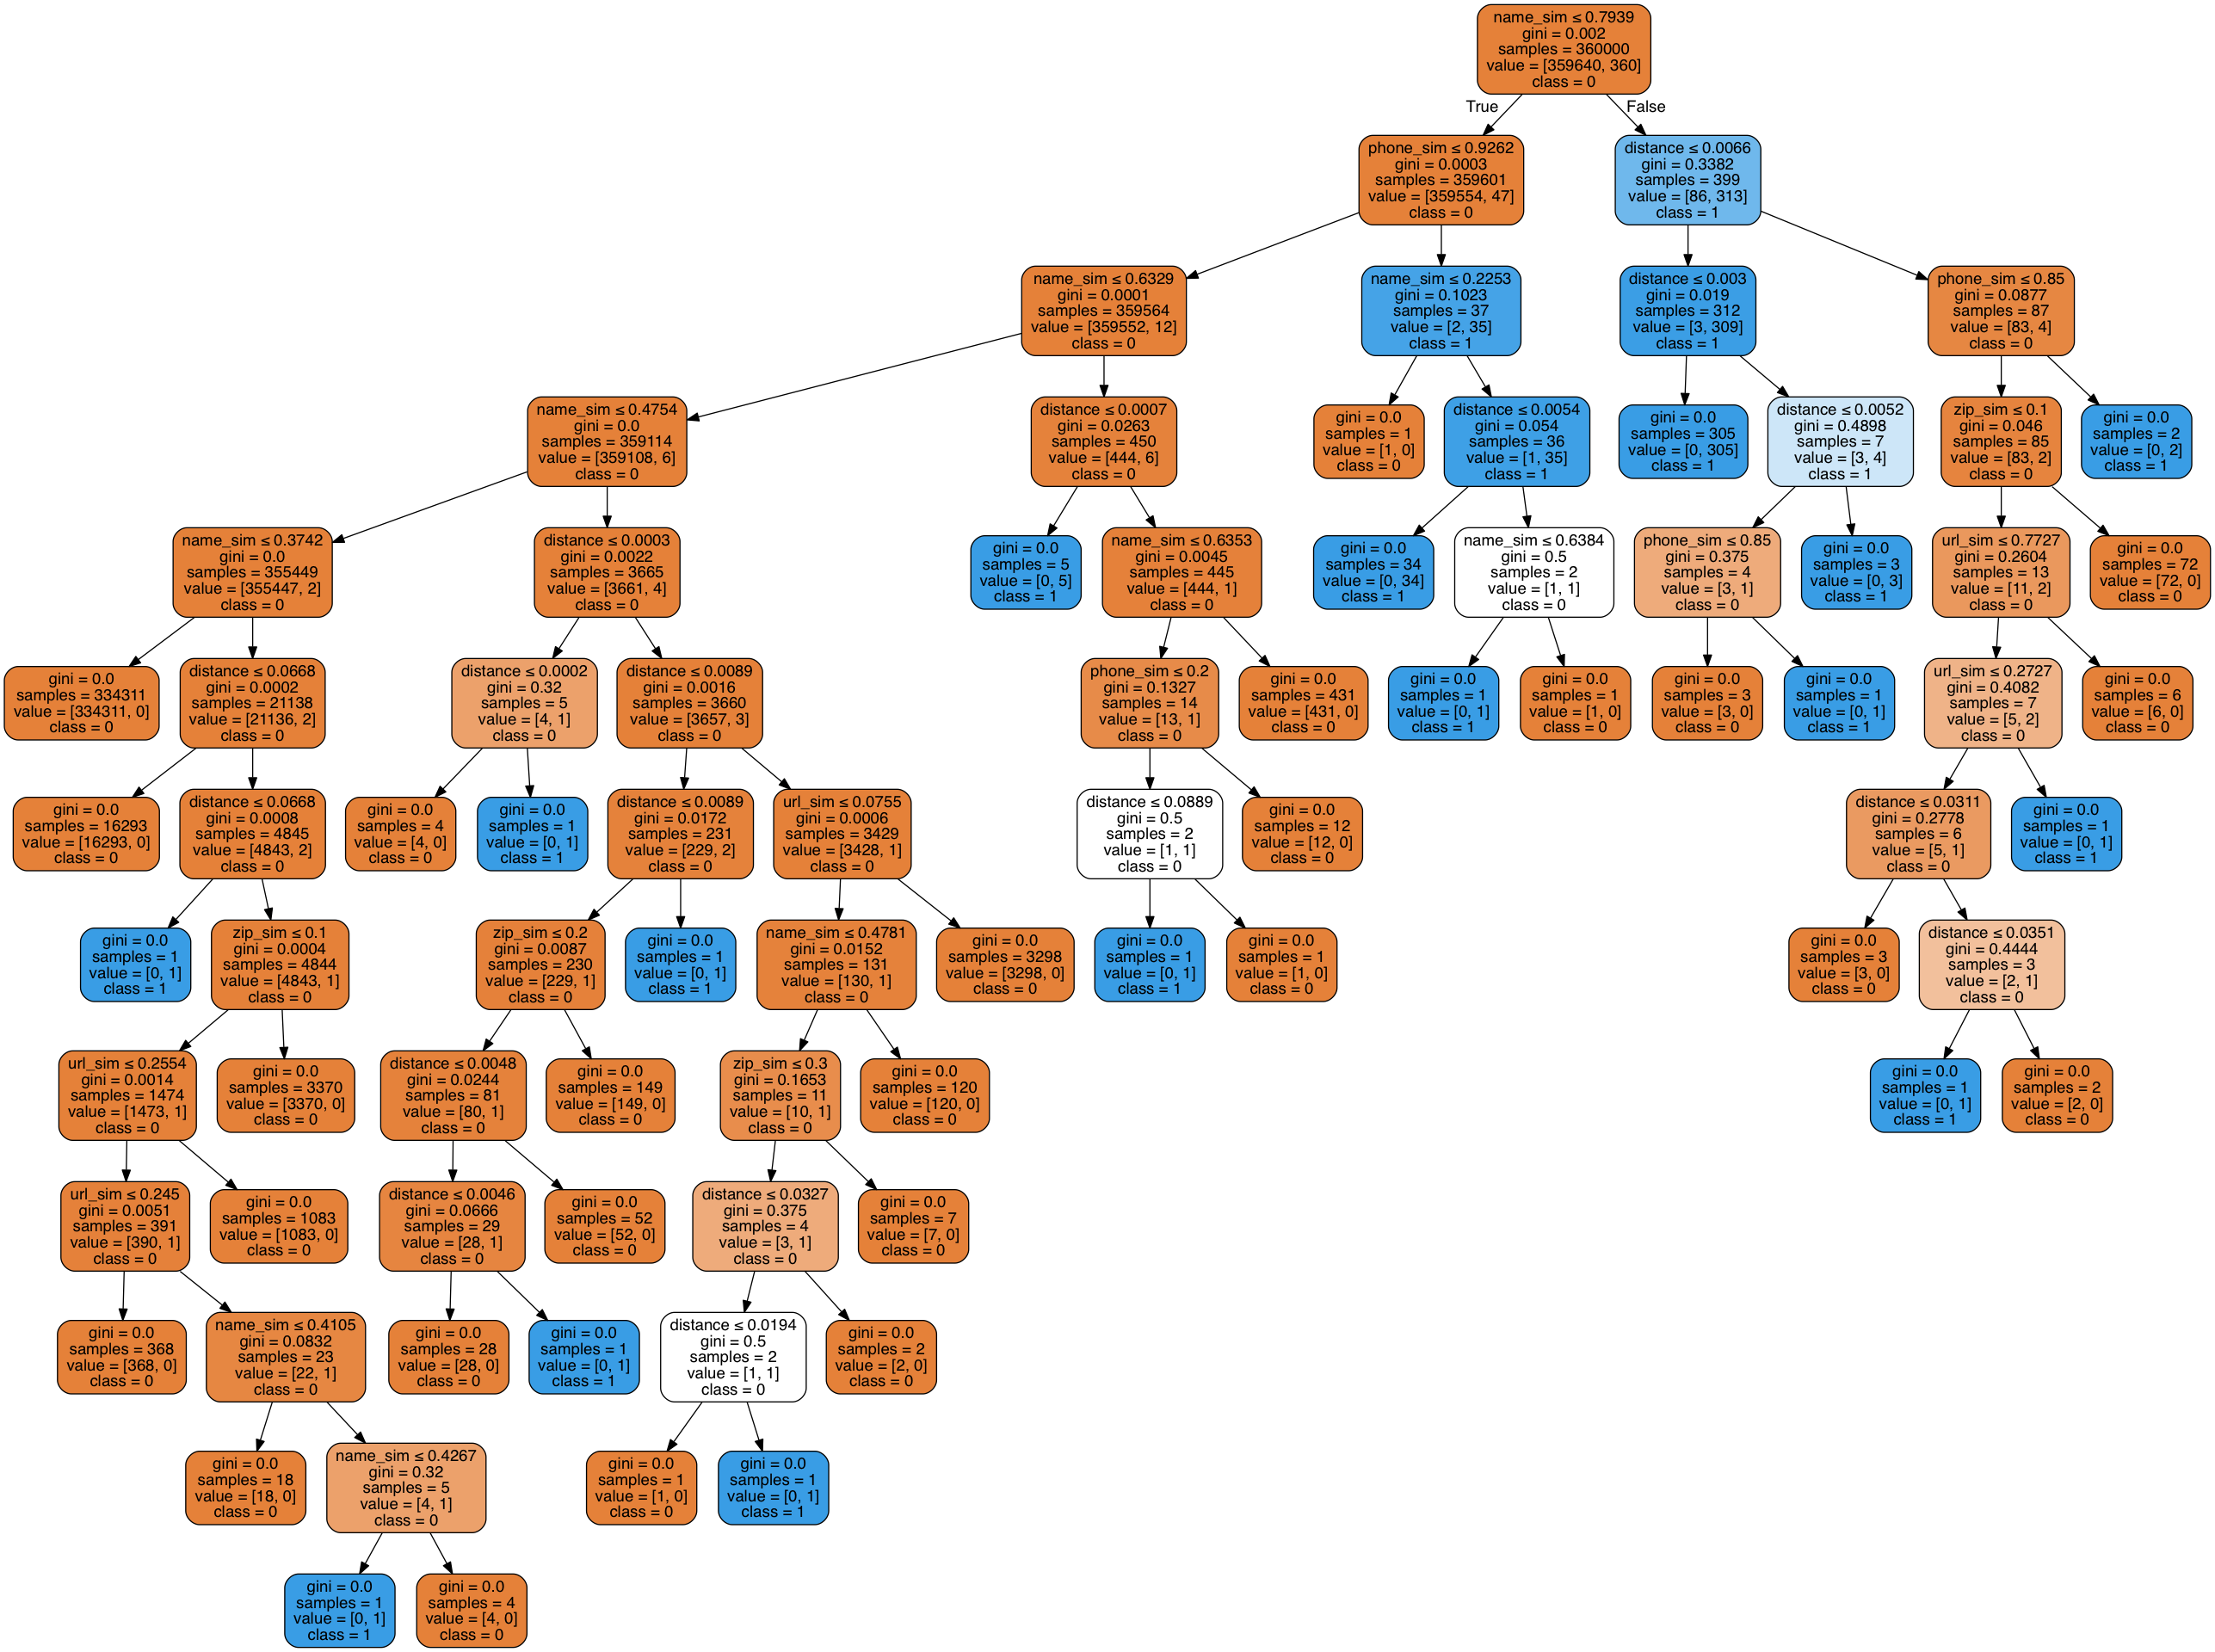

In [35]:
clf = DecisionTreeClassifier(max_features=None, random_state=2).fit(train_data, match_column)

from IPython.display import Image
from sklearn.externals.six import StringIO
from sklearn import tree
import pydotplus

dot_data = StringIO()
tree.export_graphviz(clf, out_file=dot_data,  
                         feature_names = train_data.columns,
                         class_names = ['0','1'],
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  

In [ ]:
## 
## add dumies for missing values in train and test.
for column in train_data:
    print(train_data[column])

In [16]:
## run decision tree with all the data and return probabilities
from sklearn.tree import DecisionTreeClassifier


def cv_run_dt(train_data, train_labels, test_data, test_labels):
    model = DecisionTreeClassifier(max_features=None, random_state=1).fit(train_data, train_labels)
    return model.predict(test_data)

probs = cv_run_dt(train_data, match_column, test_data, 1)

In [17]:
#run a model with all the data and predict probs and the labels on test
# model = AdaBoostClassifier(random_state=1).fit(train_data, match_column)
# model = DecisionTreeClassifier(random_state=1).fit(train_data, match_column)
model = ExtraTreesClassifier(n_estimators=50, max_features=None, random_state=1).fit(train_data, match_column)
labels = model.predict(test_data)
# probs = model.predict_proba(test_data)[:,1] # not used yet

In [18]:
import csv

# Build and export the file
lc_col = test['lc_id'][labels.astype(bool)]
fs_col = test['fs_id'][labels.astype(bool)]

output = pd.concat([lc_col, fs_col], axis=1)
output.columns = ['locu_id', 'foursquare_id']

with open('results/20160412-7(ET).csv', 'w') as f:
    output.to_csv(f, index=False, columns = ['locu_id', 'foursquare_id'])

## Sample CSV write code

In [17]:
# import csv

# username = "woojink"
# repo = "best-entity-resolvers"
# f = ib.open('/{0}/{1}/fs/Instabase%20Drive/files/matches.csv'.format(username,repo))

# # with open('output.csv', 'w') as csvfile:
# writer = csv.writer(f)

# header = ['locu_id', 'foursquare_id']
# writer.writerow(header)
# for key, val in matches_pred_test.iteritems():
#     writer.writerow([key, val])
    
# f.close()

In [26]:
train.columns

Index([u'lc_id', u'lc_latitude', u'lc_longitude', u'lc_name', u'lc_phone',
       u'lc_postal_code', u'lc_street_address', u'lc_website', u'lc_house',
       u'lc_street_name', u'lc_street_type', u'lc_suite_num', u'lc_suite_type',
       u'fs_id', u'fs_latitude', u'fs_longitude', u'fs_name', u'fs_phone',
       u'fs_postal_code', u'fs_street_address', u'fs_website', u'fs_house',
       u'fs_street_name', u'fs_street_type', u'fs_suite_num',
       u'fs_suite_type'],
      dtype='object')

In [42]:
test = None
type(test)

NoneType